In [1]:
import requests
import json
from os import path
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### API CONFIGUATION

In [2]:
BASE_URL = "https://rest.coinapi.io/"

API_KEY = "AE6EB1CB-8CD4-400E-80A6-A3A8792CB183"

### API SERVICE

In [3]:
class APIService:
    def __init__(self, assets, ticker_period):
        self.assets = assets
        self.ticker_period = ticker_period
        self.headers = {
            'Accept': 'text/plain',
            'X-CoinAPI-Key': API_KEY
        }
        self.base_url = BASE_URL
        self.payload = {}

    def get_dates_intervals(self, start_date, end_date, max_days):
        diff = end_date - start_date
        diff_days = abs(diff.days)
        dates_intervals = []
        interval_begin_date = start_date

        while diff_days > 0:
            nb_days_to_add = max_days - 1
            if diff_days < max_days - 1:
                nb_days_to_add = diff_days
            interval_end_date = interval_begin_date + timedelta(nb_days_to_add)
            dates_intervals.append([interval_begin_date, interval_end_date])
            diff_days -= nb_days_to_add + 1
            interval_begin_date = interval_end_date + timedelta(1)

        return dates_intervals

    def get_exchange_rates(self, start_date, end_date):
        start_date_str = start_date.strftime("%Y-%m-%d")
        end_date_str = (end_date + timedelta(1)).strftime("%Y-%m-%d")

        url = f"{self.base_url}v1/exchangerate/{self.assets}/history?period_id={self.ticker_period}&time_start={start_date_str}T00:00:00&time_end={end_date_str}T00:00:00"

        response = requests.request("GET", url, headers=self.headers, data=self.payload)

        if response.status_code == 200:
            return json.loads(response.text)
        else:
            print(f"API Error: {response.status_code}")
            return None

    def get_exchange_rates_extended(self, start_date, end_date):
        rates = []
        date_intervals = self.get_dates_intervals(start_date, end_date, 100)
        for interval in date_intervals:
            interval_rates = self.get_exchange_rates(interval[0], interval[1])
            if interval_rates:
                rates += interval_rates
        return rates

    def get_filtered_rates(self, start_date, end_date):
        rates = self.get_exchange_rates_extended(start_date, end_date)
        return self.filter_inconsistent_rate_values(rates)

    def filter_inconsistent_rate_values(self, input_rates):
        def rate_is_inconsistent(rate):
            v = rate["rate_open"]
            vmin = v / 10
            vmax = v * 10
            if not vmin <= rate["rate_close"] <= vmax:
                return True
            if not vmin <= rate["rate_high"] <= vmax:
                return True
            if not vmin <= rate["rate_low"] <= vmax:
                return True
            return False

        filtered_rates = []
        for i, r in enumerate(input_rates):
            if rate_is_inconsistent(r):
                reference_rate = input_rates[i - 1] if i > 0 else input_rates[i + 1]
                r["rate_open"] = reference_rate["rate_open"]
                r["rate_close"] = reference_rate["rate_close"]
                r["rate_high"] = reference_rate["rate_high"]
                r["rate_low"] = reference_rate["rate_low"]
            filtered_rates.append(r)
        return filtered_rates

### RATES DATA MANAGER

In [4]:
class RatesDataManager:
    def __init__(self, api_service):
        self.api_service = api_service

    def load_json_data_from_file(self, filename):
        """Load rates data from the JSON file."""
        with open(filename, "r") as f:
            return json.load(f)

    def save_rates_data_to_file(self, filename, rates_data):
        """Save the rates data to a JSON file."""
        with open(filename, "w") as f:
            json.dump(rates_data, f)

    def convert_rates_to_date_value_format(self, rates_data):
        """Convert rates data to the desired date-value format."""

        return [{"Date": r["time_period_start"][:10], "Close": r["rate_close"]} for r in rates_data]

    def get_and_manage_rates_data(self, assets, start_date, end_date, ticker_period):
        """Helper to generate the file name for saving JSON data."""
        data_filename = assets.replace("/", "_") + ".json"
        rates = []

        if path.exists(data_filename):
            rates = self.load_json_data_from_file(data_filename)
            if rates:
                # Convert str date to date objet
                saved_data_date_start = datetime.strptime(rates[0]["Date"], "%Y-%m-%d").date()
                saved_data_date_end = datetime.strptime(rates[-1]["Date"], "%Y-%m-%d").date()

                # Is the new end_date greater than the one already saved (saved_data_date_end)?
                if start_date < saved_data_date_start:
                    print(f"Fetching data from {start_date} to {saved_data_date_start - timedelta(1)}")
                    rates_start = self.api_service.get_filtered_rates(start_date, saved_data_date_start - timedelta(1))
                    rates = self.convert_rates_to_date_value_format(rates_start) + rates

                # Is the new end_date greater than the one already saved (saved_data_date_end)?
                if end_date > saved_data_date_end:
                    print(f"Fetching data from {saved_data_date_end + timedelta(1)} to {end_date}")
                    rates_end = self.api_service.get_filtered_rates(saved_data_date_end + timedelta(1), end_date)
                    rates += self.convert_rates_to_date_value_format(rates_end)

                # Consolidate data (update json file)
                self.save_rates_data_to_file(data_filename, rates)
            else:
                rates = self._fetch_and_save_rates(data_filename, assets, start_date, end_date)
        else:
            rates = self._fetch_and_save_rates(data_filename, assets, start_date, end_date)

        return rates

    def _fetch_and_save_rates(self, filename, assets, start_date, end_date):
        rates = self.api_service.get_filtered_rates(start_date, end_date)
        rates = self.convert_rates_to_date_value_format(rates)
        self.save_rates_data_to_file(filename, rates)
        return rates

### MAIN

In [6]:
ticker = "EUR/USD"
ticker_period = "1DAY"
start_date = date(2014, 10, 21)
# end_date = date.today() - timedelta(1)
end_date = date(2021, 1, 21)

# Initialize API service and data manager
api_service = APIService(ticker, ticker_period)
data_manager = RatesDataManager(api_service)

# Fetch and manage rates data
rates = data_manager.get_and_manage_rates_data(ticker, start_date, end_date, ticker_period)
print(rates)
print("Total rates fetched:", len(rates))
rates_dates = [datetime.strptime(r["Date"], "%Y-%m-%d") for r in rates]
rates_values = [r["Close"] for r in rates]

[{'Date': '2014-10-21', 'Close': 1.270781505334}, {'Date': '2014-10-22', 'Close': 1.26202332290876}, {'Date': '2014-10-23', 'Close': 1.26029560532322}, {'Date': '2014-10-24', 'Close': 1.26130667360218}, {'Date': '2014-10-25', 'Close': 1.25643071772364}, {'Date': '2014-10-26', 'Close': 1.25668909977459}, {'Date': '2014-10-27', 'Close': 1.25277714281734}, {'Date': '2014-10-28', 'Close': 1.26081701209287}, {'Date': '2014-10-29', 'Close': 1.25556149810931}, {'Date': '2014-10-30', 'Close': 1.26897549366496}, {'Date': '2014-10-31', 'Close': 1.24918758288457}, {'Date': '2014-11-01', 'Close': 1.25169748498089}, {'Date': '2014-11-02', 'Close': 1.25125322326596}, {'Date': '2014-11-03', 'Close': 1.24736442430475}, {'Date': '2014-11-04', 'Close': 1.2619090096757}, {'Date': '2014-11-05', 'Close': 1.25293115440107}, {'Date': '2014-11-06', 'Close': 1.25513409047169}, {'Date': '2014-11-07', 'Close': 1.25007650688676}, {'Date': '2014-11-08', 'Close': 1.25469935628802}, {'Date': '2014-11-09', 'Close': 1

# 2. Data Exploration & Visualization

In [8]:
df = pd.DataFrame(rates)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [10]:
df.shape

(2285, 1)

In [11]:
df.isna().sum()

Close    0
dtype: int64

In [12]:
df.describe() 

,Close
count,2285.000000
mean,1.134760
std,0.048057
min,1.009493
25%,1.102383
50%,1.125270
75%,1.167000
max,1.306332


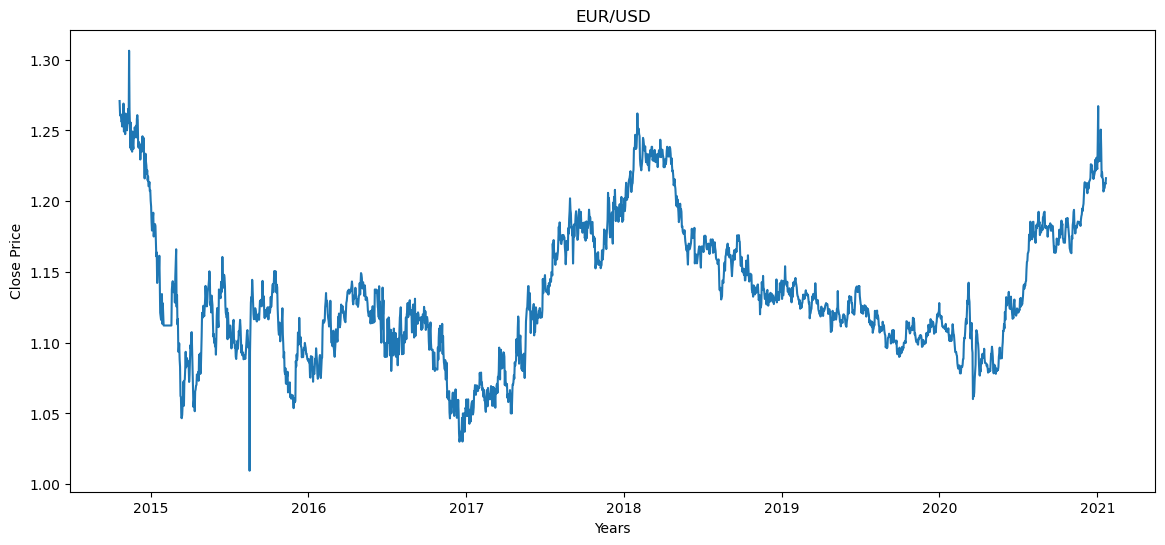

In [19]:
plt.figure(figsize=(14, 6))
plt.plot(df.Close);
plt.title(ticker);
plt.xlabel('Years');
plt.ylabel('Close Price');

### 100 days Moving Average

In [15]:
df['MA_100'] = df.Close.rolling(100).mean()
df.head(103)

,Close,MA_100
Date,,
2014-10-21,1.270782,NaN
2014-10-22,1.262023,NaN
2014-10-23,1.260296,NaN
2014-10-24,1.261307,NaN
2014-10-25,1.256431,NaN
...,...,...
2015-01-27,1.134363,NaN
2015-01-28,1.113276,1.220647
2015-01-29,1.127860,1.219218


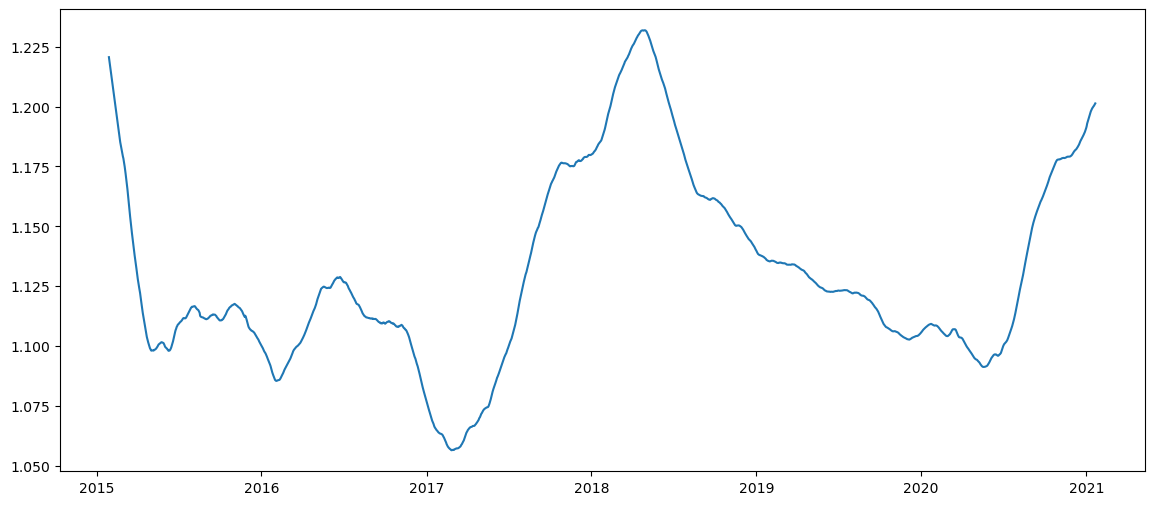

In [16]:
plt.figure(figsize=(14, 6))
plt.plot(df['MA_100'])

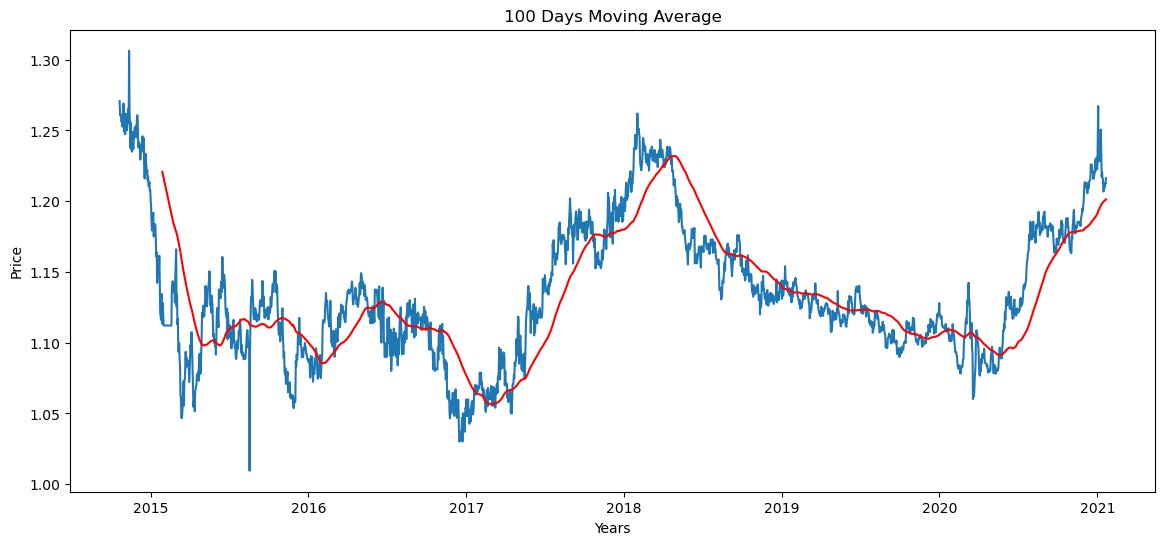

In [18]:
plt.figure(figsize=(14, 6))
plt.plot(df.Close);
plt.plot(df['MA_100'], 'r')
plt.title('100 Days Moving Average');
plt.xlabel('Years');
plt.ylabel('Price');

### 200 days Moving Average

In [20]:
df['MA_200'] = df.Close.rolling(200).mean()
df.head(203)

,Close,MA_100,MA_200
Date,,,
2014-10-21,1.270782,NaN,NaN
2014-10-22,1.262023,NaN,NaN
2014-10-23,1.260296,NaN,NaN
2014-10-24,1.261307,NaN,NaN
2014-10-25,1.256431,NaN,NaN
...,...,...,...
2015-05-07,1.130354,1.098113,NaN
2015-05-08,1.140129,1.098381,1.159514
2015-05-09,1.133761,1.098440,1.158829


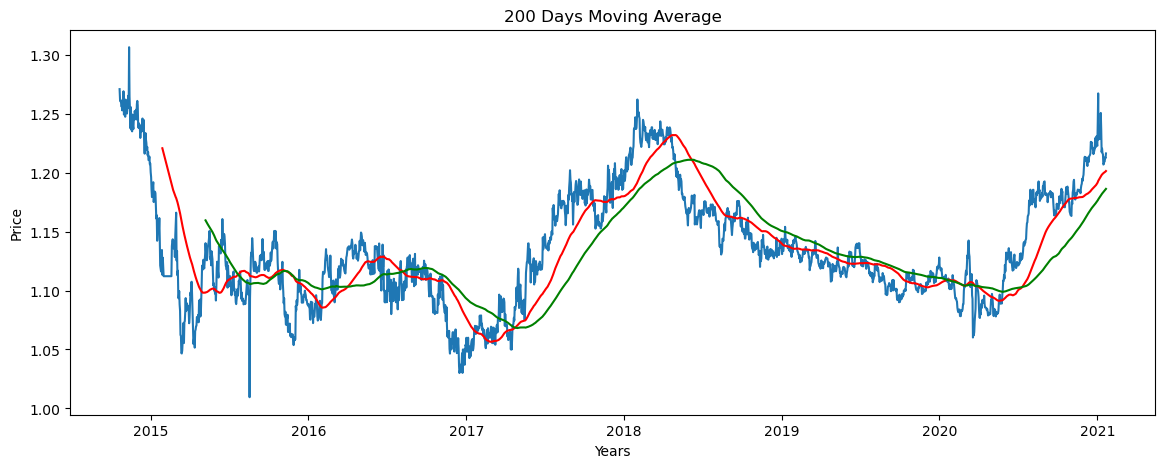

In [21]:
plt.figure(figsize=(14, 5))
plt.plot(df.Close);
plt.plot(df['MA_100'], 'r')
plt.plot(df['MA_200'], 'g')
plt.title('200 Days Moving Average');
plt.xlabel('Years');
plt.ylabel('Price');

### Calculating % changed in each trading session

In [22]:
df['Percentage Changed'] = df.Close.pct_change()
df[['Close', 'Percentage Changed']]

,Close,Percentage Changed
Date,,
2014-10-21,1.270782,NaN
2014-10-22,1.262023,-0.006892
2014-10-23,1.260296,-0.001369
2014-10-24,1.261307,0.000802
2014-10-25,1.256431,-0.003866
...,...,...
2021-01-17,1.209471,0.001746
2021-01-18,1.209505,0.000028
2021-01-19,1.212952,0.002850


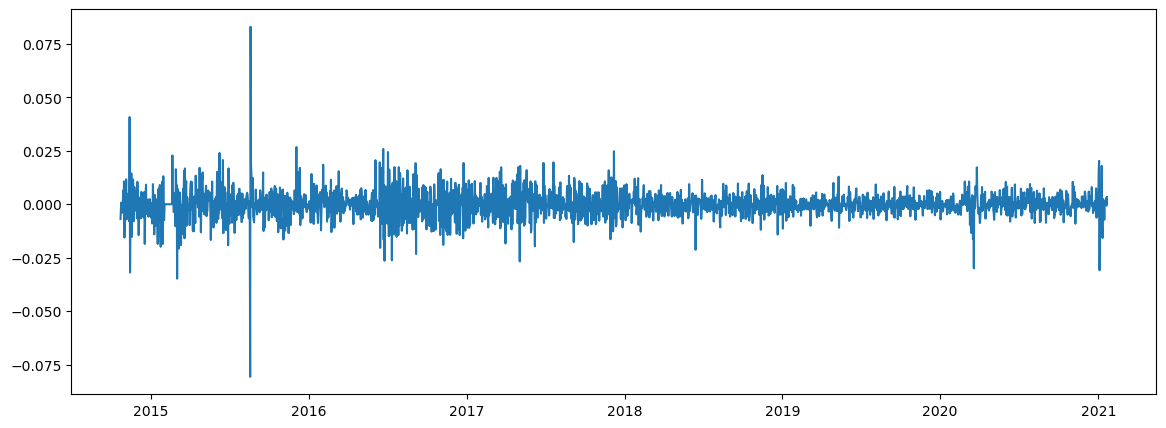

In [23]:
plt.figure(figsize=(14, 5))
plt.plot(df['Percentage Changed']);

# 4. Data Processing

In [24]:
df.shape

(2285, 4)

In [25]:
# Splitting data into Training and Testing datasets
data_training = pd.DataFrame(df.Close)

In [27]:
type(data_training)

pandas.core.frame.DataFrame

# Scaling down the data between 0 & 1

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [29]:
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.88023588],
       [0.85073104],
       [0.84491066],
       ...,
       [0.68541967],
       [0.68274941],
       [0.6965496 ]])

In [30]:
type(data_training_array)

numpy.ndarray

In [31]:
data_training_array.shape

(2285, 1)

# 5. Sequence Creation

In [32]:
# Set window size (number of previous days used to predict the next day)
window_size = 100

In [37]:
# Function for creating training sets from data
def create_dataset(data_training_array, window_size):
    x, y = [], []
    for i in range(window_size, data_training_array.shape[0]):
        x.append(data_training_array[i-window_size:i, 0])  # Inputs: previous “window_size” days
        y.append(data_training_array[i, 0])  # Output: current day
    return np.array(x), np.array(y)

In [38]:
# Créer les ensembles d'entraînement
x_train, y_train = create_dataset(data_training_array, window_size)

In [43]:
# Reshape data for LSTM [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [44]:
x_train

array([[[0.88023588],
        [0.85073104],
        [0.84491066],
        ...,
        [0.39883346],
        [0.4206654 ],
        [0.34962794]],

       [[0.85073104],
        [0.84491066],
        [0.84831677],
        ...,
        [0.4206654 ],
        [0.34962794],
        [0.39875886]],

       [[0.84491066],
        [0.84831677],
        [0.8318905 ],
        ...,
        [0.34962794],
        [0.39875886],
        [0.37366578]],

       ...,

       [[0.58111604],
        [0.58794085],
        [0.55427449],
        ...,
        [0.66658854],
        [0.67369075],
        [0.67380538]],

       [[0.58794085],
        [0.55427449],
        [0.55175885],
        ...,
        [0.67369075],
        [0.67380538],
        [0.68541967]],

       [[0.55427449],
        [0.55175885],
        [0.54318548],
        ...,
        [0.67380538],
        [0.68541967],
        [0.68274941]]])

In [45]:
y_train

array([0.39875886, 0.37366578, 0.34576501, ..., 0.68541967, 0.68274941,
       0.6965496 ])

In [46]:
x_train.shape

(2185, 100, 1)

# 6. Model Building

In [48]:
# Ml Model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Dropout

In [50]:
model = Sequential()

model.add(Input(shape=(window_size, 1))) # Couche d'entrée
model.add(LSTM(units=128, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))  # Dropout after the first LSTM
model.add(LSTM(units=64))
model.add(Dropout(0.2))  # Dropout after the second LSTM
model.add(Dense(25)) # 25 unique results will be produced
model.add(Dense(1)) # it combines them into a single output. It gives the final price forecast.

# 7. Model Training

In [52]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model on all available historical data
model.fit(x_train, y_train, batch_size=64, epochs=50)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 50s 267ms/step - loss: 0.0467
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 255ms/step - loss: 0.0041
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 272ms/step - loss: 0.0026
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 282ms/step - loss: 0.0027
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 366ms/step - loss: 0.0024
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 260ms/step - loss: 0.0022
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step - loss: 0.0023
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 262ms/step - loss: 0.0020
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 267ms/step - loss: 0.0019
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 258ms/step - loss: 0.0021
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 262ms/step - loss: 0.0017
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - loss: 0.0019
Epoch 13/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 276ms/step - loss: 0.0017
Epoch 14/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 253ms/step - loss: 0.0017
Epoch 15/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 

In [53]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 100, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,625 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 352,859 (1.35 MB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,240 (918.91 KB)

In [54]:
# save the trained model
model.save('future_prediction_Algo_LSTM_model.keras')

# 8. Making Predictions

In [55]:
# last_100_days' is the last 100-day window of normalized data used for training.
last_100_days = data_training_array[-100:]

In [56]:
last_100_days

array([[0.55175885],
       [0.54318548],
       [0.54350923],
       [0.54321594],
       [0.54270949],
       [0.56740512],
       [0.58364336],
       [0.60023822],
       [0.58073041],
       [0.5992859 ],
       [0.60187632],
       [0.59080382],
       [0.57774631],
       [0.56515729],
       [0.55197042],
       [0.52978152],
       [0.52565417],
       [0.52031763],
       [0.51970764],
       [0.51786739],
       [0.55891834],
       [0.55194404],
       [0.58494023],
       [0.59283341],
       [0.61608014],
       [0.62112502],
       [0.58453104],
       [0.57506215],
       [0.56485258],
       [0.57495309],
       [0.5830464 ],
       [0.5777928 ],
       [0.58162568],
       [0.58952324],
       [0.59341842],
       [0.5892505 ],
       [0.58897527],
       [0.59172002],
       [0.59176969],
       [0.59002492],
       [0.58287949],
       [0.59741388],
       [0.60574657],
       [0.60987671],
       [0.62410862],
       [0.6181622 ],
       [0.62931663],
       [0.635

In [57]:
type(last_100_days)

numpy.ndarray

In [58]:
last_100_days.shape

(100, 1)

In [61]:
predictions = []

# Make 100 predictions
for _ in range(100):
    # Reshape the model to accept data
    x_input = last_100_days.reshape(1, -1, 1)  # Reshape en (1, 100, 1)
    
    # Make a prediction
    predicted_price = model.predict(x_input)
    
    # Add prediction to list
    predictions.append(predicted_price[0, 0])
    
    # Update data window for next prediction
    last_100_days = np.append(last_100_days, predicted_price)[-100:]  # Keep last 100 days (including new prediction)
    # Reverse normalization if necessary (if we've normalized the data beforehand)

# Convert predictions to NumPy array to use .reshape()
predictions = np.array(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━

In [62]:
predictions

array([0.21106136, 0.21100983, 0.21095973, 0.21091107, 0.21086375,
       0.21081778, 0.2107731 , 0.21072972, 0.2106875 , 0.21064653,
       0.21060668, 0.21056794, 0.21053033, 0.21049377, 0.21045822,
       0.21042371, 0.21039015, 0.21035753, 0.21032585, 0.21029507,
       0.21026514, 0.21023604, 0.21020778, 0.21018031, 0.21015362,
       0.21012768, 0.21010248, 0.210078  , 0.21005419, 0.21003106,
       0.2100086 , 0.20998678, 0.20996556, 0.20994493, 0.20992492,
       0.20990545, 0.2098865 , 0.20986812, 0.20985025, 0.20983288,
       0.209816  , 0.20979959, 0.20978364, 0.20976815, 0.20975313,
       0.2097385 , 0.20972429, 0.20971045, 0.20969708, 0.20968404,
       0.20967135, 0.20965904, 0.20964709, 0.20963547, 0.20962417,
       0.20961316, 0.20960249, 0.20959215, 0.20958208, 0.20957227,
       0.20956276, 0.2095535 , 0.2095445 , 0.20953578, 0.20952731,
       0.20951904, 0.20951103, 0.20950325, 0.20949571, 0.20948832,
       0.20948118, 0.20947425, 0.20946749, 0.20946094, 0.20945

In [63]:
# Reverse normalization of predictions
predicted_prices = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Display predicted_prices
predicted_prices

array([1.0721445, 1.0721292, 1.0721143, 1.0720999, 1.0720859, 1.0720721,
       1.0720589, 1.072046 , 1.0720335, 1.0720214, 1.0720096, 1.071998 ,
       1.0719869, 1.071976 , 1.0719655, 1.0719552, 1.0719453, 1.0719355,
       1.0719261, 1.071917 , 1.0719081, 1.0718995, 1.0718911, 1.071883 ,
       1.0718751, 1.0718673, 1.0718598, 1.0718526, 1.0718455, 1.0718387,
       1.071832 , 1.0718255, 1.0718192, 1.0718131, 1.0718071, 1.0718014,
       1.0717957, 1.0717902, 1.071785 , 1.0717798, 1.0717748, 1.07177  ,
       1.0717652, 1.0717607, 1.0717561, 1.0717518, 1.0717475, 1.0717435,
       1.0717396, 1.0717356, 1.0717319, 1.0717282, 1.0717247, 1.0717212,
       1.0717179, 1.0717146, 1.0717114, 1.0717084, 1.0717053, 1.0717025,
       1.0716996, 1.0716969, 1.0716943, 1.0716916, 1.0716891, 1.0716866,
       1.0716842, 1.071682 , 1.0716797, 1.0716776, 1.0716754, 1.0716734,
       1.0716714, 1.0716693, 1.0716676, 1.0716658, 1.0716639, 1.0716622,
       1.0716605, 1.0716588, 1.0716572, 1.0716556, 

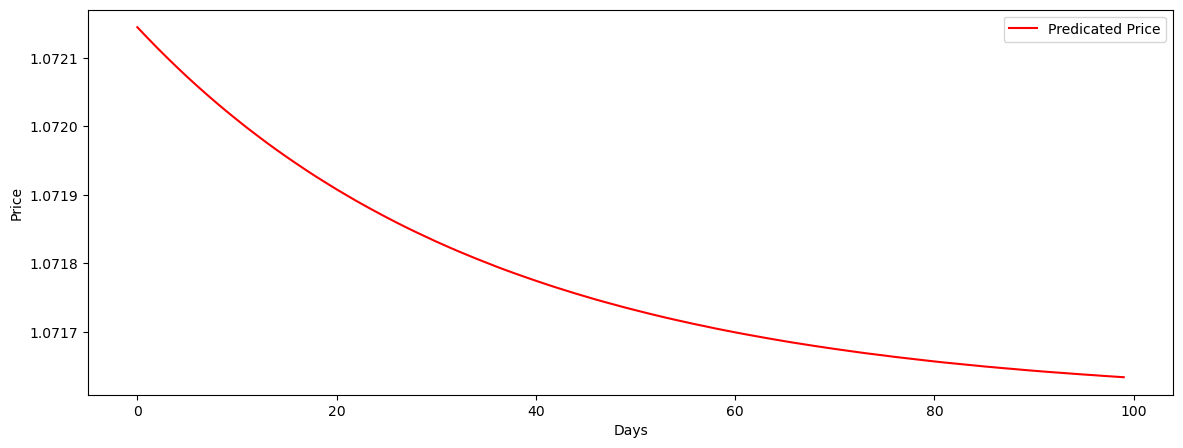

In [65]:
plt.figure(figsize=(14, 5))

plt.plot(predicted_prices, 'r', label='Predicated Price')
plt.xlabel('Days');
plt.ylabel('Price');
plt.legend()